In [1]:
DATE = "2021-08-25"
TASK = "k-medoids-error-cluster-detection-multi-entity"
DIR = mkpath("$(homedir())/$(DATE)-$(TASK)")

"/home/jovyan/2021-08-25-k-medoids-error-cluster-detection-multi-entity"

In [2]:
import Pkg
pkgs = [
#     "BioAlignments",
    "BioSequences",
    "Clustering",
#     "CodecZlib",
#     "Colors",
#     "Combinatorics",
    "DataFrames",
#     "DataStructures",
    "Dates",
#     "DelimitedFiles",
    "Distances",
#     "EzXML",
    "FASTX",
#     "GFF3",
#     "HTTP",
#     "Impute",
#     "JSON",
    "LightGraphs",
    "LSHFunctions",
#     "Measures",
    "MetaGraphs",
    "https://github.com/cjprybol/Mycelia.git",
#     "NumericIO",
#     "PlotlyJS",
#     "Plots",
    "Primes",
#     "Printf",
    "ProgressMeter",
    "Random",
    "Revise",
    "SparseArrays",
    "Statistics",
    "StatsBase",
    "StatsPlots",
#     "StringDistances",
#     "uCSV",
#     "XLSX",
]

unregistered_packages = filter(pkg -> occursin(r"(^https|git$)", pkg), pkgs)
registered_packages = setdiff(pkgs, unregistered_packages)

for pkg in registered_packages
    try
        eval(Meta.parse("import $(pkg)"))
    catch
        Pkg.add(pkg)
        Pkg.build(pkg)
        eval(Meta.parse("import $(pkg)"))
    end
end

for pkg_url in unregistered_packages
    pkg_name = replace(basename(pkg_url), ".git" => "")
    try
        eval(Meta.parse("import $(pkg_name)"))
    catch
        Pkg.develop(url=pkg_url)
        Pkg.build(pkg_name)
        eval(Meta.parse("import $(pkg_name)"))
    end
end

┌ Info: Precompiling Mycelia [453d265d-8292-4a7b-a57c-dce3f9ae6acd]
└ @ Base loading.jl:1317


In [3]:
if Sys.isapple()
    BANDAGE = "/Applications/Bandage.app/Contents/MacOS/Bandage"
else
    BANDAGE = "Bandage"
end

"Bandage"

In [4]:
function assess_kmer_sparsity_in_reads(k, observations)
#     @show k, observations
    canonical_kmer_counts = Mycelia.count_canonical_kmers(BioSequences.DNAMer{k}, observations)
#     canonical_kmer_counts = Mycelia.count_canonical_kmers(BioSequences.DNAMer{k}, first(observations))
# #     @show canonical_kmer_counts
#     for i in 2:length(observations)
#         canonical_kmer_counts_ = Mycelia.count_canonical_kmers(BioSequences.DNAMer{k}, observations[i])
#         canonical_kmer_counts = merge!(+, canonical_kmer_counts, canonical_kmer_counts_)
#     end
#     canonical_kmer_counts = map(o -> Mycelia.count_canonical_kmers(BioSequences.DNAMer{k}, o), observations)...)
    total_observed_canonical_kmers = length(keys(canonical_kmer_counts))
    total_possible_canonical_kmers = (4^k)/2
    sparsity = round(total_observed_canonical_kmers/total_possible_canonical_kmers*100, sigdigits=3)
    @show sparsity
    return sparsity
end

assess_kmer_sparsity_in_reads (generic function with 1 method)

In [5]:
function sequence_to_canonical_kmers(kmer_type, sequence)
    return (BioSequences.canonical(kmer.fw) for kmer in BioSequences.each(kmer_type, sequence))
end

sequence_to_canonical_kmers (generic function with 1 method)

In [6]:
function determine_edge_weights(graph)
    outgoing_edge_probabilities = determine_edge_weights(graph, true)
    incoming_edge_probabilities = determine_edge_weights(graph, false)
    return Dict(true => outgoing_edge_probabilities, false => incoming_edge_probabilities)
end

determine_edge_weights (generic function with 1 method)

In [7]:
function determine_edge_weights(graph, strand)
    kmers = [graph.vprops[v][:kmer] for v in LightGraphs.vertices(graph)]
    outgoing_edge_weights = SparseArrays.spzeros(length(kmers), length(kmers))
    
    for (kmer_index, kmer) in enumerate(kmers)
        if !strand
            kmer = BioSequences.reverse_complement(kmer)
        end
        
        downstream_neighbors = []
        downstream_neighbor_weights = []
        for neighbor in BioSequences.neighbors(kmer)
            canonical_neighbor = BioSequences.canonical(neighbor)
            neighbor_orientation = neighbor == canonical_neighbor
            
            neighbor_index_range = searchsorted(kmers, canonical_neighbor)
            if !isempty(neighbor_index_range)
                @assert length(neighbor_index_range) == 1
                neighbor_index = first(neighbor_index_range)
                if LightGraphs.has_edge(graph, LightGraphs.Edge(kmer_index, neighbor_index))
                    edge_orientations = graph.eprops[LightGraphs.Edge(kmer_index, neighbor_index)][:orientations]
                    this_edge_orientation = (source_orientation = strand, destination_orientation = neighbor_orientation)
                    if this_edge_orientation in edge_orientations
                        edge_weight = graph.eprops[LightGraphs.Edge(kmer_index, neighbor_index)][:weight]
                        outgoing_edge_weights[kmer_index, neighbor_index] = edge_weight
                    end
                end
            end
        end
    end
    return outgoing_edge_weights
end

determine_edge_weights (generic function with 2 methods)

In [8]:
function determine_edge_probabilities(edge_weights)
    edge_probabilities = deepcopy(edge_weights)
    for orientation in [true, false]
        for row in 1:size(edge_probabilities[orientation], 1)
            edge_weights = edge_probabilities[orientation][row, :]
            edge_total = sum(edge_weights)
            for (col, edge_weight) in enumerate(edge_weights)
                if edge_total > 0
                    edge_probabilities[orientation][row, col] = edge_weight/edge_total
                else
                    edge_probabilities[orientation][row, col] = 0.0
                end
            end
        end
    end
    return edge_probabilities
end

determine_edge_probabilities (generic function with 1 method)

In [9]:
function random_step(current_vertex, current_orientation, step_probabilities)
    outgoing_edge_likelihoods = step_probabilities[initial_orientation][current_vertex, :]
    chosen_step = StatsBase.sample(outgoing_edge_likelihoods.nzind, StatsBase.weights(outgoing_edge_likelihoods.nzval))
    possible_orientations = observation_graph.eprops[LightGraphs.Edge(current_vertex, chosen_step)][:orientations]
    possible_orientations = filter(o -> o.source_orientation == current_orientation, possible_orientations)
    chosen_orientation = rand(possible_orientations).destination_orientation
    chosen_oriented_step = (vertex = chosen_step, orientation = chosen_orientation)
    return chosen_oriented_step
end

random_step (generic function with 1 method)

In [10]:
function random_walk(observation_graph, initial_vertex, initial_orientation, step_probabilities; n_steps=size(step_probabilities[true], 1))
    step_count = 0
    outgoing_edge_likelihoods = step_probabilities[initial_orientation][initial_vertex, :]
    walk = Vector{NamedTuple{(:vertex, :orientation), Tuple{Int64, Bool}}}()
    done = (step_count >= n_steps) || (sum(outgoing_edge_likelihoods) == 0)
    current_vertex = initial_vertex
    current_orientation = initial_orientation
    while !done
#         @show "choosing"
        chosen_step = StatsBase.sample(outgoing_edge_likelihoods.nzind, StatsBase.weights(outgoing_edge_likelihoods.nzval))
        chosen_step
        possible_orientations = observation_graph.eprops[LightGraphs.Edge(current_vertex, chosen_step)][:orientations]
        possible_orientations
        current_orientation
        possible_orientations = filter(o -> o.source_orientation == current_orientation, possible_orientations)
        possible_orientations
        chosen_orientation = rand(possible_orientations).destination_orientation
        chosen_oriented_step = (vertex = chosen_step, orientation = chosen_orientation)
        push!(walk, chosen_oriented_step)
        current_vertex = chosen_step
        current_orientation = chosen_orientation
        outgoing_edge_likelihoods = step_probabilities[last(walk).orientation][last(walk).vertex, :]
        step_count += 1
#         @show outgoing_edge_likelihoods
        done = (step_count >= n_steps) || (sum(outgoing_edge_likelihoods) == 0)
    end
    return walk
end

random_walk (generic function with 1 method)

In [11]:
# km = vmax/2 = optimal number of reads
# slope is less than 10%?

In [12]:
# generate genomes
fasta_records = []
sequence_lengths = [10, 100]
weights = [10, 1]
for (sequence_length, depth) in zip(sequence_lengths, weights)
    sequence = BioSequences.randdnaseq(Random.seed!(sequence_length), sequence_length)
    sequence_id = string(hash(sequence))
    description = string(depth)
    fasta_record = FASTX.FASTA.Record(sequence_id, description, sequence)
    push!(fasta_records, fasta_record)
end

In [13]:
file_basename = join(["L-$(length(FASTX.sequence(record)))" for record in fasta_records], '_')
reference_fasta_file = "$(DIR)/$(file_basename).fasta"
open(reference_fasta_file, "w") do io
    fastx_io = FASTX.FASTA.Writer(io)
    for fasta_record in fasta_records
        write(fastx_io, fasta_record)
    end
    close(fastx_io)
end

In [63]:
# randomly sample reads with errors from the genome
error_rate = 0.01
n_reads = 1000

1000

In [64]:
observations = [Mycelia.observe(StatsBase.sample(fasta_records, StatsBase.Weights(weights)), error_rate = error_rate) for i in 1:n_reads];

In [65]:
# determine distribution of read lengths

In [66]:
sorted_read_lengths = sort(length.(FASTX.sequence.(observations)))

1000-element Vector{Int64}:
   9
   9
   9
   9
   9
   9
   9
   9
   9
   9
   9
   9
   9
   ⋮
 101
 101
 101
 101
 101
 101
 101
 102
 102
 102
 102
 102

In [67]:
first_percentile_read_length = sorted_read_lengths[Int(round(length(sorted_read_lengths) * .01))]

9

In [68]:
Primes.primes(min_k, max_k)

2-element Vector{Int64}:
 5
 7

In [69]:
# determine optimal k
min_k = min(5, first_percentile_read_length)
max_k = min(61, first_percentile_read_length)
k_options = Primes.primes(min_k, max_k)
k_index = findfirst(k -> assess_kmer_sparsity_in_reads(k, observations) < .01, k_options)
if k_index == nothing
    k = k_options[end]
else
    k = k_options[k_index]
end
@show k

sparsity = 58.8
sparsity = 6.52
k = 7


7

In [70]:
observations_file = "$(DIR)/$(file_basename)-DEPTH-$(n_reads).fastq"
open(observations_file, "w") do io
    fastq_io = FASTX.FASTQ.Writer(io)
    for record in observations
        write(fastq_io, record)
    end
    close(fastq_io)
end

# Begin graph resolving of observation graph

In [71]:
# assess kmer counts

In [72]:
# fit linear trendline to kmer counts

In [73]:
# apply thresholding when constructing kmer graph at the trendline

In [74]:
kmer_counts = Mycelia.count_canonical_kmers(BioSequences.DNAMer{k}, observations_file)

OrderedCollections.OrderedDict{BioSequences.DNAMer{7}, Int64} with 534 entries:
  AAACCAG => 1
  AAACGCG => 1
  AAAGCCC => 1
  AAAGCGC => 74
  AAAGCGT => 1
  AAATCTA => 1
  AACATAC => 1
  AACATAG => 77
  AACCAGC => 1
  AACCGCA => 1
  AACCTAC => 1
  AACGATC => 1
  AACGCGC => 1
  AACTATG => 1
  AAGAATA => 1
  AAGATAC => 1
  AAGATAG => 73
  AAGATAT => 1
  AAGCCCC => 1
  AAGCCTG => 3
  AAGCGCC => 76
  AAGCGTC => 1
  AAGGTAG => 1
  AAGTGAC => 1
  AAGTGGA => 76
  ⋮       => ⋮

In [75]:
kmer_counts_histogram = sort(collect(StatsBase.countmap(values(kmer_counts))), by=x->x[1])

21-element Vector{Pair{Int64, Int64}}:
   1 => 337
   2 => 62
   3 => 21
   4 => 11
   5 => 3
   6 => 2
   7 => 1
  71 => 1
  72 => 3
  73 => 5
  74 => 11
  75 => 16
  76 => 18
  77 => 22
  78 => 9
  79 => 6
  80 => 2
 863 => 1
 869 => 1
 870 => 1
 933 => 1

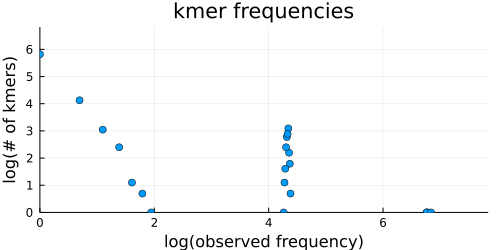

In [79]:
scale = 250
Mycelia.plot_kmer_frequency_spectra(values(kmer_counts), size=(2scale,scale), logscale=log2, title="kmer frequencies")

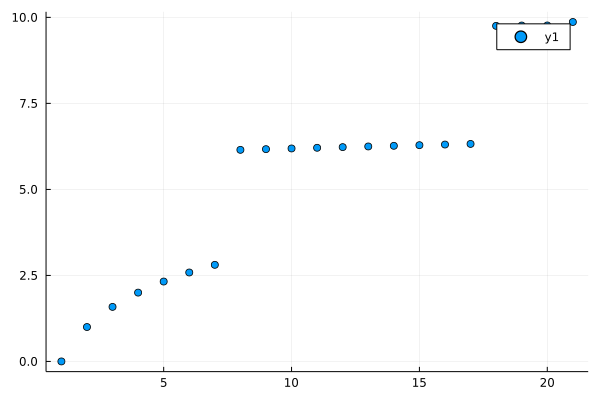

In [80]:
StatsPlots.scatter(log2.(first.(kmer_counts_histogram)))

# Fit error cluster

In [81]:
kmer_depth_of_coverage_bins = log2.(first.(kmer_counts_histogram))

21-element Vector{Float64}:
 0.0
 1.0
 1.584962500721156
 2.0
 2.321928094887362
 2.584962500721156
 2.807354922057604
 6.149747119504682
 6.169925001442312
 6.189824558880018
 6.20945336562895
 6.22881869049588
 6.247927513443585
 6.266786540694901
 6.285402218862249
 6.303780748177103
 6.321928094887363
 9.753216749178955
 9.7632123668144
 9.76487159073609
 9.86573327085176

In [82]:
distance_matrix = zeros((length(kmer_depth_of_coverage_bins), length(kmer_depth_of_coverage_bins)))
for (row, depth_of_coverage_bin_1) in enumerate(kmer_depth_of_coverage_bins)
    for (col, depth_of_coverage_bin_2) in enumerate(kmer_depth_of_coverage_bins)
        distance = abs(depth_of_coverage_bin_1 - depth_of_coverage_bin_2)
        distance_matrix[row, col] = distance
    end
end
distance_matrix

21×21 Matrix{Float64}:
 0.0      1.0       1.58496   2.0       …  9.76321     9.76487     9.86573
 1.0      0.0       0.584963  1.0          8.76321     8.76487     8.86573
 1.58496  0.584963  0.0       0.415037     8.17825     8.17991     8.28077
 2.0      1.0       0.415037  0.0          7.76321     7.76487     7.86573
 2.32193  1.32193   0.736966  0.321928     7.44128     7.44294     7.54381
 2.58496  1.58496   1.0       0.584963  …  7.17825     7.17991     7.28077
 2.80735  1.80735   1.22239   0.807355     6.95586     6.95752     7.05838
 6.14975  5.14975   4.56478   4.14975      3.61347     3.61512     3.71599
 6.16993  5.16993   4.58496   4.16993      3.59329     3.59495     3.69581
 6.18982  5.18982   4.60486   4.18982      3.57339     3.57505     3.67591
 6.20945  5.20945   4.62449   4.20945   …  3.55376     3.55542     3.65628
 6.22882  5.22882   4.64386   4.22882      3.53439     3.53605     3.63691
 6.24793  5.24793   4.66297   4.24793      3.51528     3.51694     3.61781
 6

In [83]:
# distance_matrix = zeros((length(kmer_counts_histogram), length(kmer_counts_histogram)))
# for (row, kmer_count_pair_1) in enumerate(kmer_counts_histogram)
#     for (col, kmer_count_pair_2) in enumerate(kmer_counts_histogram)
# #         distance = abs(depth_of_coverage_bin_1 - depth_of_coverage_bin_2)
#         distance = Distances.euclidean([kmer_count_pair_1...], [kmer_count_pair_2...])
#         distance_matrix[row, col] = distance
#     end
# end
# distance_matrix

In [84]:
ks = Primes.primes(2, 17)
ys = map(k ->
            Statistics.mean(Statistics.mean(Clustering.silhouettes(Clustering.kmedoids(distance_matrix, k), distance_matrix)) for i in 1:100),
            ks)

7-element Vector{Float64}:
 0.6888401786852689
 0.8198797807365382
 0.7327209473843409
 0.6117007295548419
 0.3792933650242293
 0.27523722984293314
 0.15920503639821224

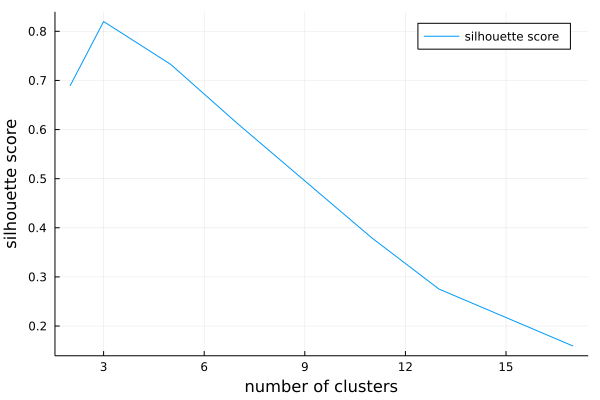

In [85]:
StatsPlots.plot(ks, ys, label="silhouette score", ylabel = "silhouette score", xlabel = "number of clusters")

In [86]:
ymax, ymax_index = findmax(ys)

(0.8198797807365382, 2)

In [87]:
optimal_k = ks[ymax_index]

3

In [88]:
clusterings = [Clustering.kmedoids(distance_matrix, optimal_k) for i in 1:10]

max_value, max_value_index = findmax(clustering -> Statistics.mean(Clustering.silhouettes(clustering, distance_matrix)), clusterings)

(0.9001787434932467, 2)

In [89]:
optimal_clustering = clusterings[max_value_index]

Clustering.KmedoidsResult{Float64}([12, 19, 4], [3, 3, 3, 3, 3, 3, 3, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 2, 2, 2, 2], [2.0, 1.0, 0.4150374992788439, 0.0, 0.3219280948873622, 0.5849625007211561, 0.8073549220576042, 0.07907157099119821, 0.05889368905356829, 0.03899413161586285  …  0.0, 0.019108822947704773, 0.0379678501990206, 0.05658352836636826, 0.07496205768122266, 0.09310940439148219, 0.009995617635444987, 0.0, 0.001659223921690156, 0.10252090403735892], [10, 4, 7], 5.721515142652818, 1, true)

In [90]:
optimal_clustering.assignments

21-element Vector{Int64}:
 3
 3
 3
 3
 3
 3
 3
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 2
 2
 2
 2

In [91]:
min_medoid_value, min_medoid_index = findmin(optimal_clustering.medoids)

(4, 3)

In [93]:
indices_to_include = map(assignment -> assignment .!= min_medoid_index, optimal_clustering.assignments)

21-element Vector{Bool}:
 0
 0
 0
 0
 0
 0
 0
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [100]:
threshold = log2(ceil(2^maximum(kmer_depth_of_coverage_bins[.!indices_to_include])))

2.807354922057604

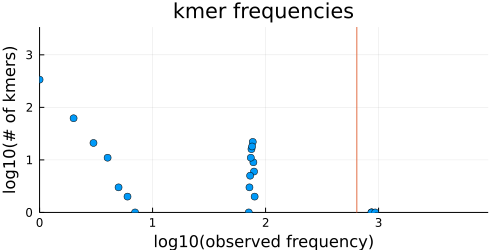

In [101]:
scale = 250
p = Mycelia.plot_kmer_frequency_spectra_log2(values(kmer_counts), size=(2scale,scale), title="kmer frequencies")
StatsPlots.vline!(p, [threshold])

In [42]:
StatsPlots.scatter(log10.(first.(kmer_counts_histogram)))

LoadError: UndefVarError: kmer_counts_histogram not defined

In [ ]:
# make me faster by counting edges ahead of time
@time observation_graph = Mycelia.fastx_to_simple_kmer_graph(BioSequences.DNAMer{k}, observations_file, minimum_coverage=threshold)

In [ ]:
kmer_counts = Dict(observation_graph.vprops[v][:kmer] => observation_graph.vprops[v][:weight] for v in LightGraphs.vertices(observation_graph))
total_observed_kmers = sum(values(kmer_counts))
kmer_probabilities = Dict(k => v/total_observed_kmers for (k,v) in kmer_counts)
scale = 250
Mycelia.plot_kmer_frequency_spectra(values(kmer_counts), size=(2scale,scale), title="kmer frequencies")

In [ ]:
reference_kmers = keys(Mycelia.count_canonical_kmers(BioSequences.DNAMer{k}, reference_fasta_file))
distance_to_reference_graph = 1 - LSHFunctions.jaccard(Set(reference_kmers), Set(keys(kmer_counts)))

In [ ]:
kmer_counts_histogram = sort(collect(StatsBase.countmap(collect(values(kmer_counts)))), by=x->x[1])

In [ ]:
# visualize
gfa_file = observations_file * ".k-$k.gfa"
Mycelia.graph_to_gfa(observation_graph, gfa_file)

run(`$(BANDAGE) image $(gfa_file) $(gfa_file).svg --depwidth .9 --deppower .9`)
# --nodewidth <float> Average node width (0.5 to 1000, default: 5)
# --depwidth <float>  Depth effect on width (0 to 1, default: 0.5)
# --deppower <float>  Power of depth effect on width (0 to 1, default: 0.5)

html_path_to_svg = "./" * repeat("../", length(split(pwd(), '/')) - 3)
html_path_to_svg *= replace("$(gfa_file).svg", "$(homedir())/" => "")

x = "<img src=$(html_path_to_svg)>"
display("text/html", x)
# display("image/svg+xml", read("$(gfa_file).svg", String))

In [ ]:
# step 2, re-simulate reads as a means of error correction

In [ ]:
kmer_probabilities = values(kmer_counts) ./ sum(values(kmer_counts))

In [ ]:
edge_weights = determine_edge_weights(observation_graph)

In [ ]:
edge_weights[true]

In [ ]:
@time edge_weights = determine_edge_weights(observation_graph)
@time edge_probabilities = determine_edge_probabilities(edge_weights)

In [ ]:
step_probabilities = copy(edge_probabilities)
for orientation in [true, false]
    oriented_step_probabilities = step_probabilities[orientation] 
    for row in 1:size(step_probabilities[orientation], 1)
        step_probabilities_ = step_probabilities[orientation][row, :] .* kmer_probabilities
        if sum(step_probabilities_) > 0
            step_probabilities[orientation][row, :] .= step_probabilities_ ./ sum(step_probabilities_)
        end
    end
end

In [ ]:
# observation = first(observations)

In [ ]:
# FASTX.sequence(observation)

In [ ]:
# kmers = collect(keys(kmer_counts))

In [ ]:
# mers = collect(BioSequences.each(eltype(kmers), FASTX.sequence(observation)))
# index_is_solid = falses(length(mers))
# for (i, mer) in enumerate(mers)
#     canonical_mer = min(mer.fw, mer.bw)
# #     @show canonical_mer
#     canonical_mer_in_graph = !isempty(searchsorted(kmers, canonical_mer))
# #     @show canonical_mer_in_graph
#     index_is_solid[i] = canonical_mer_in_graph
# end
# @show index_is_solid

In [ ]:
# solid_mer_indices = findall(index_is_solid)

In [ ]:
# first_solid_mer_index = findfirst(index_is_solid)

In [ ]:
# first_solid_mer = mers[first_solid_mer]

In [ ]:
# canonical_mer = min(first_solid_mer.fw, first_solid_mer.bw)

In [ ]:
# orientation = first_solid_mer.fw == canonical_mer

In [ ]:
# determine vertex and orientation of solid kmer

In [ ]:
# indices = searchsorted(kmers, canonical_mer)
# @assert length(indices) == 1
# index = first(indices)

In [ ]:
# walk backward index - 1 steps and put that into the read

In [ ]:
# backwards_walk = random_walk(observation_graph, index, !orientation, step_probabilities; n_steps=first_solid_mer_index-1)

In [ ]:
# initial_walk = map(x -> (vertex=x.vertex, orientation=!x.orientation), reverse(backwards_walk))

In [ ]:
# current_solid_mer_index = first_solid_mer_index
# current_solid_mer = mers[current_solid_mer_index]

In [ ]:
# current_solid_mer_orientation = orientation

In [ ]:
# next_solid_mer_index = findnext(index_is_solid, current_solid_mer_index+1)

In [ ]:
# next_solid_mer = mers[next_solid_mer_index]

In [ ]:
# next_solid_mer_orientation = next_solid_mer.fw <= next_solid_mer.bw

In [ ]:
# yen 3 shortest paths between previous solid kmer and this solid kmer

In [ ]:
# determine probability of each possible new path

In [ ]:
# accept paths according to relative probability

In [ ]:
# put into the read

In [ ]:
# if end is not solid, random walk from last solid kmer to total number of steps

In [ ]:
# Mycelia.sequence_to_oriented_path(FASTX.sequence(observation), collect(keys(kmer_counts)))

In [ ]:
ProgressMeter.@showprogress for observation in observations
    read_length = length(FASTX.sequence(observation))
    max_steps = read_length - observation_graph.gprops[:k]
    # apply a squaring penalty to kmer_weights?
    initial_vertex = StatsBase.sample(1:length(kmers), StatsBase.weights(kmer_probabilities.^2))
#     @show "choosing initial vertex $initial_vertex with probability $(kmer_weights[initial_vertex])"
    initial_orientation = rand(Bool)
    forward_walk = random_walk(observation_graph, initial_vertex, initial_orientation, step_probabilities, n_steps=max_steps)
    remaining_steps = max_steps - length(forward_walk)
    reverse_walk = random_walk(observation_graph, initial_vertex, !initial_orientation, step_probabilities, n_steps = remaining_steps)
    full_walk = [[(vertex=x.vertex, orientation=!x.orientation) for x in reverse(reverse_walk)]..., [(vertex = initial_vertex, orientation = initial_orientation)]..., forward_walk...]
    oriented_path = [(x.vertex, x.orientation) for x in full_walk]
    new_seq = Mycelia.oriented_path_to_sequence(observation_graph, oriented_path)
    new_record = FASTX.FASTQ.Record(
        FASTX.identifier(observation)*"-k$k",
        FASTX.identifier(observation),
        new_seq,
        StatsBase.sample(FASTX.quality(observation), length(new_seq))
    )
#     @show "here"
    push!(new_records, new_record)
end
new_records;

In [ ]:
corrected_fastq_file = replace(observations_file, r"\.fastq" => ".k$k.fastq")
open(corrected_fastq_file, "w") do io
    fastq_writer = FASTX.FASTQ.Writer(io)
    for record in new_records
        write(fastq_writer, record)
    end
    close(fastq_writer)
end

In [ ]:
corrected_observation_graph = Mycelia.fastx_to_kmer_graph(BioSequences.DNAMer{k}, corrected_fastq_file)

In [ ]:
# visualize
gfa_file = corrected_fastq_file * ".k-$k.gfa"
Mycelia.graph_to_gfa(corrected_observation_graph, gfa_file)

run(`$(BANDAGE) image $(gfa_file) $(gfa_file).svg --depwidth .9 --deppower .9`)
# --nodewidth <float> Average node width (0.5 to 1000, default: 5)
# --depwidth <float>  Depth effect on width (0 to 1, default: 0.5)
# --deppower <float>  Power of depth effect on width (0 to 1, default: 0.5)

html_path_to_svg = "./" * repeat("../", length(split(pwd(), '/')) - 3)
html_path_to_svg *= replace("$(gfa_file).svg", "$(homedir())/" => "")

x = "<img src=$(html_path_to_svg)>"
display("text/html", x)
# display("image/svg+xml", read("$(gfa_file).svg", String))

In [ ]:
kmer_counts = Dict(corrected_observation_graph.vprops[v][:kmer] => corrected_observation_graph.vprops[v][:weight] for v in LightGraphs.vertices(corrected_observation_graph))
total_observed_kmers = sum(values(kmer_counts))
kmer_probabilities = Dict(k => v/total_observed_kmers for (k,v) in kmer_counts)
scale = 250
Mycelia.plot_kmer_frequency_spectra(values(kmer_counts), size=(2scale,scale), title="kmer frequencies")

In [ ]:
# compare the new graph to the error-free graph to the error-corrected graph

In [ ]:
reference_kmers = keys(Mycelia.count_canonical_kmers(BioSequences.DNAMer{k}, reference_fasta_file))
distance_to_reference_graph = 1 - LSHFunctions.jaccard(Set(reference_kmers), Set(keys(kmer_counts)))

# Final polish and reduction

In [ ]:
# to_filter = Int[]
connected_component = first(LightGraphs.connected_components(corrected_observation_graph))

In [ ]:
tip_vertices = filter(v -> LightGraphs.degree(corrected_observation_graph, v) == 2, LightGraphs.vertices(corrected_observation_graph))

In [ ]:
if length(tip_vertices) > 2
    component_weights = map(v -> corrected_observation_graph.vprops[v][:weight], connected_component)
    component_median = Statistics.median(component_weights)
    component_standard_deviation = Statistics.std(component_weights)
    tips_to_drop = filter(tip -> corrected_observation_graph.vprops[tip][:weight] < component_median - 2*component_standard_deviation, tip_vertices) 
    polished_graph, vertex_map = LightGraphs.induced_subgraph(corrected_observation_graph, setdiff(LightGraphs.vertices(corrected_observation_graph), tips_to_drop))
    simplified_graph = Mycelia.simplify_kmer_graph(polished_graph)
else
    simplified_graph = Mycelia.simplify_kmer_graph(corrected_observation_graph)
end

In [ ]:
# write simplified graph to gfa
# visualize
gfa_file = corrected_fastq_file * ".k-$k.simplified.gfa"
Mycelia.graph_to_gfa(simplified_graph, gfa_file)

run(`$(BANDAGE) image $(gfa_file) $(gfa_file).svg --depwidth .9 --deppower .9`)
# --nodewidth <float> Average node width (0.5 to 1000, default: 5)
# --depwidth <float>  Depth effect on width (0 to 1, default: 0.5)
# --deppower <float>  Power of depth effect on width (0 to 1, default: 0.5)

html_path_to_svg = "./" * repeat("../", length(split(pwd(), '/')) - 3)
html_path_to_svg *= replace("$(gfa_file).svg", "$(homedir())/" => "")

x = "<img src=$(html_path_to_svg)>"
display("text/html", x)
# display("image/svg+xml", read("$(gfa_file).svg", String))

In [ ]:
simplified_graph.vprops[1][:weight]

In [ ]:
Mycelia.is_equivalent(FASTX.sequence(fasta_record), simplified_graph.vprops[1][:sequence])

# THE SAME!!!

In [ ]:
# write contigs to fasta
final_fasta_file = corrected_fastq_file * ".k-$k.simplified.fasta"
open(final_fasta_file, "w") do io
    fasta_io = FASTX.FASTA.Writer(io)
    for vertex in LightGraphs.vertices(simplified_graph)
        seq = simplified_graph.vprops[vertex][:sequence]
        description = string(simplified_graph.vprops[vertex][:weight])
        id = string(hash(seq)) * '-' * string(Dates.now())
        record = FASTX.FASTA.Record(id, description, seq)
        @show record
        write(fasta_io, record)
    end
    close(fasta_io)
end